<a href="https://colab.research.google.com/github/AmalZubidat/Cereal-Breakfast-type-classification-CNN/blob/main/Final_Cereal_breakfast_training_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
Amal Zubidat with AI

Summary of project:

- Stage 1: Setup and dataset inspection
- Stage 2: Compute class weights
- Stage 3: Build augmentation and tf.data pipelines
- Stage 4: Build MobileNetV2 model
- Stage 5: Train head with class_weight or oversampling
- Stage 6: Fine-tune
- Stage 7: Evaluate with confusion matrix and per-class precision/recall
- Stage 8: Optional k-fold cross-validation

"""

Downloading libraries

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


# --------------------------
# STAGE 1: Setup and dataset inspection
# --------------------------

In [ ]:
# Dataset path and categories
# DATA_ROOT = '/content/drive/MyDrive/Datasets'
# CEREAL_CATEGORIES = ['CiniMinis', 'דליפקאן', 'CRUNSH WAVES', 'קורנפלקס פיטניס', 'קוקומן כדורים', 'Nesquik']
IMG_SIZE = (224, 224)
BATCH_SIZE = 12
AUTOTUNE = tf.data.AUTOTUNE

GPU INFO

In [ ]:
# GPU info
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('WARNING: GPU not found.')
else:
  print('GPU detected:', device_name)

GPU detected: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Dataset path and categories
DATA_ROOT = os.path.join(os.getcwd(), '/content/drive/MyDrive/HW2-HEAT_private/Datasets_Clean_Haya')
print(os.path.exists(DATA_ROOT))
CEREAL_CATEGORIES = os.listdir(DATA_ROOT)
print(CEREAL_CATEGORIES)

True
['CiniMinis', 'Cocoman', 'CrunshWaves', 'Fitness', 'Dilpecan', 'Kariot', 'Shoogie', 'Oogie', 'Nesquik', 'TelmaAlofim']


# --------------------------
# STAGE 2: Prepare dataset paths and labels
# --------------------------

In [ ]:
# --------------------------
# STAGE 2: Prepare dataset paths and labels
# --------------------------
image_counts = {}
path_images = {}


for category in CEREAL_CATEGORIES:
    category_path = os.path.join(DATA_ROOT, category)
    if os.path.exists(category_path):
        files = glob.glob(os.path.join(category_path, '*.jpg')) + \
                glob.glob(os.path.join(category_path, '*.jpeg')) + \
                glob.glob(os.path.join(category_path, '*.png'))
        image_counts[category] = len(files)
        path_images[category] = category_path
    else:
        print(f"WARNING: Path not found for {category}: {category_path}")
        image_counts[category] = 0
        path_images[category] = None


# Display results
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
total_images = sum(image_counts.values())
print(f"Total images: {total_images}\n")



# # Split dataset: train 80%, val 10%, test 10%
# train_paths, test_paths, train_labels, test_labels = train_test_split(all_paths, all_labels, test_size=0.1, stratify=all_labels, random_state=42)
# train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.1111, stratify=train_labels, random_state=42)
# print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


DATASET OVERVIEW
Total images: 250



In [ ]:
print("Image counts per category:")
for category in CEREAL_CATEGORIES:
    count = image_counts[category]
    percentage = (count / total_images * 100) if total_images > 0 else 0
    print(f"  {category:20s}: {count:3d} images ({percentage:5.1f}%)")

print("\n" + "="*60)
print(f"Min images per class: {min(image_counts.values())}")
print(f"Max images per class: {max(image_counts.values())}")
print(f"Avg images per class: {total_images / len(CEREAL_CATEGORIES):.1f}")
print("="*60)


Image counts per category:
  CiniMinis           :  18 images (  7.2%)
  Cocoman             :  30 images ( 12.0%)
  CrunshWaves         :  54 images ( 21.6%)
  Fitness             :  35 images ( 14.0%)
  Dilpecan            :  11 images (  4.4%)
  Kariot              :  40 images ( 16.0%)
  Shoogie             :  14 images (  5.6%)
  Oogie               :  15 images (  6.0%)
  Nesquik             :  15 images (  6.0%)
  TelmaAlofim         :  18 images (  7.2%)

Min images per class: 11
Max images per class: 54
Avg images per class: 25.0


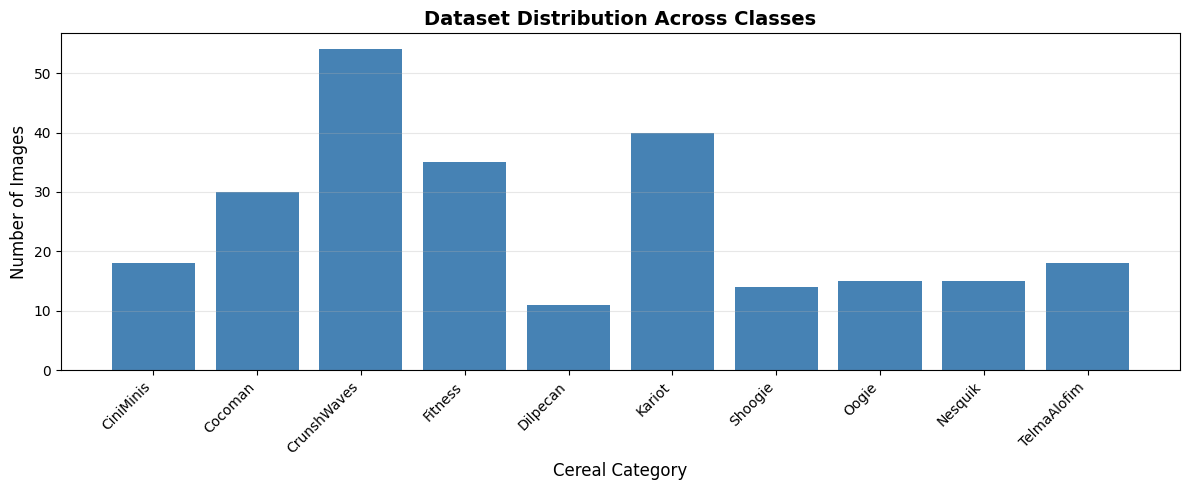


   Class weights will be critical for training


In [ ]:
# Visualize distribution
plt.figure(figsize=(12, 5))
plt.bar(CEREAL_CATEGORIES, [image_counts[c] for c in CEREAL_CATEGORIES], color='steelblue')
plt.xlabel('Cereal Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Dataset Distribution Across Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for severe imbalance
min_count = min(image_counts.values())
max_count = max(image_counts.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

if imbalance_ratio > 3:
    print(f"\nWARNING: Severe class imbalance detected (ratio: {imbalance_ratio:.1f}:1)")
    print("   Class weights will be critical for training")
elif imbalance_ratio > 2:
    print(f"\nWARNING: Moderate class imbalance detected (ratio: {imbalance_ratio:.1f}:1)")
    print("   Class weights recommended")
else:
    print(f"\nDataset is relatively balanced (ratio: {imbalance_ratio:.1f}:1)")


# PREPARE DATASET PATHS AND LABELS


In [ ]:
# ==================== PREPARE DATASET PATHS AND LABELS ====================
all_paths = []
all_labels = []

for idx, category in enumerate(CEREAL_CATEGORIES):
    folder = path_images[category]
    if folder is None:
        continue

    files = glob.glob(os.path.join(folder, '*.jpg')) + \
            glob.glob(os.path.join(folder, '*.jpeg')) + \
            glob.glob(os.path.join(folder, '*.png'))

    all_paths.extend(files)
    all_labels.extend([idx] * len(files))

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print(f"\nTotal samples collected: {len(all_paths)}")
print(f"Total labels collected: {len(all_labels)}")

# Split dataset: 60% train, 20% validation, 20% test
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_paths, all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=(0.2 / 0.80),  # 20/80
    stratify=train_val_labels,
    random_state=42
)

print("\n" + "="*60)
print("DATA SPLIT")
print("="*60)
print(f"Train set:      {len(train_paths):3d} images ({len(train_paths)/len(all_paths)*100:.1f}%)")
print(f"Validation set: {len(val_paths):3d} images ({len(val_paths)/len(all_paths)*100:.1f}%)")
print(f"Test set:       {len(test_paths):3d} images ({len(test_paths)/len(all_paths)*100:.1f}%)")
print("="*60)

# Verify stratification
print("\nClass distribution verification:")
print(f"{'Class':<20} {'Train':>8} {'Val':>8} {'Test':>8}")
print("-" * 48)
for idx, category in enumerate(CEREAL_CATEGORIES):
    train_count = np.sum(train_labels == idx)
    val_count = np.sum(val_labels == idx)
    test_count = np.sum(test_labels == idx)
    print(f"{category:<20} {train_count:>8} {val_count:>8} {test_count:>8}")



Total samples collected: 250
Total labels collected: 250

DATA SPLIT
Train set:      150 images (60.0%)
Validation set:  50 images (20.0%)
Test set:        50 images (20.0%)

Class distribution verification:
Class                   Train      Val     Test
------------------------------------------------
CiniMinis                  11        3        4
Cocoman                    18        6        6
CrunshWaves                32       11       11
Fitness                    21        7        7
Dilpecan                    7        2        2
Kariot                     24        8        8
Shoogie                     8        3        3
Oogie                       9        3        3
Nesquik                     9        3        3
TelmaAlofim                11        4        3


# --------------------------
# STAGE 3: Compute class weights
# --------------------------

In [ ]:
# --------------------------
# STAGE 3: Compute class weights
# --------------------------
num_classes = len(CEREAL_CATEGORIES)
total_count = len(train_labels)
class_weights = {i: total_count / (num_classes * np.sum(train_labels == i)) for i in range(num_classes)}
# print('Class weights:', class_weights)
print(' Num of Classes', num_classes )


print("\n" + "="*60)
print("CLASS WEIGHTS")
print("="*60)
print("\nManual calculation (used for training):")
for idx, category in enumerate(CEREAL_CATEGORIES):
    count = np.sum(train_labels == idx)
    weight = class_weights[idx]
    print(f"  {category:<20}: {weight:6.3f} (n={count})")

print("\nInterpretation:")
print("  - Weight > 1.0: Minority class (model pays MORE attention)")
print("  - Weight < 1.0: Majority class (model pays LESS attention)")
print("  - Weight ≈ 1.0: Balanced class")
print("="*60)


 Num of Classes 10

CLASS WEIGHTS

Manual calculation (used for training):
  CiniMinis           :  1.364 (n=11)
  Cocoman             :  0.833 (n=18)
  CrunshWaves         :  0.469 (n=32)
  Fitness             :  0.714 (n=21)
  Dilpecan            :  2.143 (n=7)
  Kariot              :  0.625 (n=24)
  Shoogie             :  1.875 (n=8)
  Oogie               :  1.667 (n=9)
  Nesquik             :  1.667 (n=9)
  TelmaAlofim         :  1.364 (n=11)

Interpretation:
  - Weight > 1.0: Minority class (model pays MORE attention)
  - Weight < 1.0: Majority class (model pays LESS attention)
  - Weight ≈ 1.0: Balanced class


## Configuration

In [ ]:
#Model hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 12  # Increased from 12 (RTX 5090 can handle this)
INITIAL_LEARNING_RATE = 1e-3
FINETUNE_LEARNING_RATE = 1e-5
AUTOTUNE = tf.data.AUTOTUNE

# Training configuration
EPOCHS_HEAD = 20  # Train head only
EPOCHS_FINETUNE = 15  # Fine-tuning (optional)
PATIENCE = 6  # Early stopping patience

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Number of classes: {len(CEREAL_CATEGORIES)}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Initial LR: {INITIAL_LEARNING_RATE}")
print(f"Finetune LR: {FINETUNE_LEARNING_RATE}")
print("="*60)

CONFIGURATION
Number of classes: 10
Image size: (224, 224)
Batch size: 12
Initial LR: 0.001
Finetune LR: 1e-05


# --------------------------
# STAGE 4: Data augmentation and tf.data pipeline
# --------------------------

the data augmentation happens on the fly

In [ ]:
# --------------------------
# STAGE 4: Data augmentation and tf.data pipeline
# --------------------------
DATA_AUGMENTATION = tf.keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.08),
layers.RandomTranslation(0.06, 0.06),
layers.RandomZoom(0.08),
layers.RandomContrast(0.08),
])


def create_dataset(paths, labels, batch_size=BATCH_SIZE, augment=False, shuffle=False):
  ds = tf.data.Dataset.from_tensor_slices((paths, labels))
  def _load(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img.set_shape(IMG_SIZE + (3,))
    return img, label
  ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(2048)
  if augment:
    ds = ds.map(lambda x, y: (DATA_AUGMENTATION(x, training=True), y), num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda x, y: (preprocess_input(tf.cast(x, tf.float32)), y), num_parallel_calls=AUTOTUNE)
  ds = ds.batch(batch_size).prefetch(AUTOTUNE)
  return ds


train_ds = create_dataset(train_paths, train_labels, augment=True, shuffle=True)
val_ds = create_dataset(val_paths, val_labels, augment=False, shuffle=False)
test_ds = create_dataset(test_paths, test_labels, augment=False, shuffle=False)

## Config

# --------------------------
# STAGE 5: Build MobileNetV2 model
# --------------------------

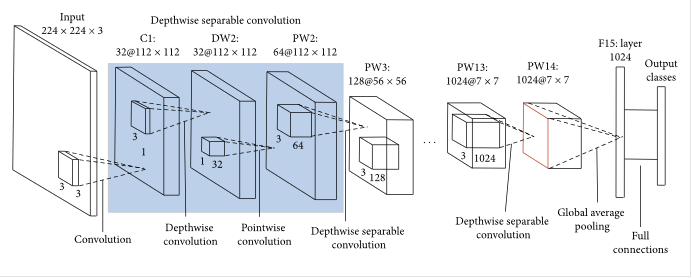

1. What is MobileNet?
As the name applied, the MobileNet model is designed to be used in mobile applications, and it is TensorFlow’s first mobile computer vision model.

MobileNet is a simple but efficient and not very computationally intensive convolutional neural networks for mobile vision applications. MobileNet is widely used in many real-world applications which includes object detection, fine-grained classifications, face attributes, and localization. In this lecture, I will explain you the overview of MobileNet and how exactly it becomes the most efficient and lightweight neural network.

MobileNet uses depthwise separable convolutions. It significantly reduces the number of parameters when compared to the network with regular convolutions with the same depth in the nets. This results in lightweight deep neural networks.

A depthwise separable convolution is made from two operations.

Depthwise convolution.
Pointwise convolution.
MobileNet is a class of CNN that was open-sourced by Google, and therefore, this gives us an excellent starting point for training our classifiers that are insanely small and insanely fast.



When MobileNets Applied to Real Life
The speed and power consumption of the network is proportional to the number of MACs (Multiply-Accumulates) which is a measure of the number of fused Multiplication and Addition operations.





The full MobileNets network has 30 layers. The design of the network is quite straightforward:

1. convolutional layer with stride 2
2. depthwise layer
3. pointwise layer that doubles the number of channels
4. depthwise layer with stride 2
5. pointwise layer that doubles the number of channels
6. depthwise layer
7. pointwise layer
8. depthwise layer with stride 2
9. pointwise layer that doubles the number of channels




and so on…

After the very first layer (a regular convolution), the depthwise and pointwise layers take turns. Sometimes the depthwise layer has a stride of 2, to reduce the width and height of the data as it flows through the network. Sometimes the pointwise layer doubles the number of channels in the data. All the convolutional layers are followed by a ReLU activation function.

This goes on for a while until the original
 image is shrunk down to
 pixels but now has 1024 channels. After this there’s an average-pooling layer that works on the entire image so that we end up with a
 image, which is really just a vector of 1024 elements.

If we’re using MobileNets as a classifier, for example on ImageNet which has 1000 possible categories, then the final layer is a fully-connected layer with a softmax and 1000 outputs. If you wanted to use MobileNets on a different dataset, or as a feature extractor instead of classifier, you’d use some other final layer instead.

In [ ]:
inputs = layers.Input(shape=IMG_SIZE + (3,))
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Classification head

In [ ]:
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

# Weighted F1 metric

In [ ]:
class WeightedF1(tf.keras.metrics.Metric):
  def __init__(self, num_classes, average='weighted', name='weighted_f1', **kwargs):
    super().__init__(name=name, **kwargs)
    self.num_classes = num_classes
    self.average = average
    self.tp = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
    self.fp = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
    self.fn = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    if y_pred.shape.rank == 2:
      y_pred_labels = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    else:
      y_pred_labels = tf.cast(y_pred, tf.int32)

    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
    y_pred_labels = tf.cast(tf.reshape(y_pred_labels, [-1]), tf.int32)

    y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes, dtype=self.dtype)
    y_pred_one_hot = tf.one_hot(y_pred_labels, depth=self.num_classes, dtype=self.dtype)

    current_tp = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
    current_fp = tf.reduce_sum((1.0 - y_true_one_hot) * y_pred_one_hot, axis=0)
    current_fn = tf.reduce_sum(y_true_one_hot * (1.0 - y_pred_one_hot), axis=0)

    self.tp.assign_add(current_tp)
    self.fp.assign_add(current_fp)
    self.fn.assign_add(current_fn)

  def result(self):
    precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
    recall = tf.math.divide_no_nan(self.tp, self.tp + self.fn)
    f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
    if self.average == 'macro':
      return tf.reduce_mean(f1)
    else:
      weights = tf.cast(self.tp + self.fn, self.dtype)
      return tf.reduce_sum(f1 * weights) / tf.reduce_sum(weights)

  def reset_states(self):
      for v in self.variables:
        v.assign(tf.zeros_like(v))

COMPILE

In [ ]:
metric_f1 = WeightedF1(num_classes)
model.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy', metric_f1])

# --------------------------
# STAGE 6: Train head
# --------------------------

In [ ]:
# --------------------------
# STAGE 6: Train head
# --------------------------
ckpt = callbacks.ModelCheckpoint('best_head.h5', save_best_only=True, monitor='val_loss')
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history_head = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD, class_weight=class_weights, callbacks=[ckpt, es])

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2699 - loss: 2.5996 - weighted_f1: 0.2661  

13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.2730 - loss: 2.5846 - weighted_f1: 0.2700 - val_accuracy: 0.6200 - val_loss: 1.1485 - val_weighted_f1: 0.5618
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5222 - loss: 1.6517 - weighted_f1: 0.5455

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 502ms/step - accuracy: 0.5292 - loss: 1.6372 - weighted_f1: 0.5513 - val_accuracy: 0.8400 - val_loss: 0.6529 - val_weighted_f1: 0.8261
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7848 - loss: 0.8892 - weighted_f1: 0.7810

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 532ms/step - accuracy: 0.7859 - loss: 0.8830 - weighted_f1: 0.7819 - val_accuracy: 0.8600 - val_loss: 0.5202 - val_weighted_f1: 0.8587
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9146 - loss: 0.3921 - weighted_f1: 0.9111

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 632ms/step - accuracy: 0.9141 - loss: 0.3915 - weighted_f1: 0.9108 - val_accuracy: 0.9400 - val_loss: 0.3132 - val_weighted_f1: 0.9320
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8532 - loss: 0.6896 - weighted_f1: 0.8568

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 461ms/step - accuracy: 0.8560 - loss: 0.6734 - weighted_f1: 0.8598 - val_accuracy: 0.8800 - val_loss: 0.3054 - val_weighted_f1: 0.8744
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9570 - loss: 0.3187 - weighted_f1: 0.9588

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 562ms/step - accuracy: 0.9563 - loss: 0.3228 - weighted_f1: 0.9580 - val_accuracy: 0.9200 - val_loss: 0.2732 - val_weighted_f1: 0.9119
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.9761 - loss: 0.1864 - weighted_f1: 0.9765 - val_accuracy: 0.9000 - val_loss: 0.3197 - val_weighted_f1: 0.8944
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 426ms/step - accuracy: 0.9317 - loss: 0.3718 - weighted_f1: 0.9300 - val_accuracy: 0.8800 - val_loss: 0.2737 - val_weighted_f1: 0.8731
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9803 - loss: 0.1013 - weighted_f1: 0.9802

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 528ms/step - accuracy: 0.9793 - loss: 0.1040 - weighted_f1: 0.9792 - val_accuracy: 0.9600 - val_loss: 0.1663 - val_weighted_f1: 0.9567
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 450ms/step - accuracy: 0.9571 - loss: 0.1964 - weighted_f1: 0.9597 - val_accuracy: 0.9400 - val_loss: 0.1974 - val_weighted_f1: 0.9367
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9700 - loss: 0.1040 - weighted_f1: 0.9703

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 465ms/step - accuracy: 0.9693 - loss: 0.1070 - weighted_f1: 0.9695 - val_accuracy: 0.9400 - val_loss: 0.1592 - val_weighted_f1: 0.9353
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 477ms/step - accuracy: 0.9574 - loss: 0.1772 - weighted_f1: 0.9592 - val_accuracy: 0.9400 - val_loss: 0.1939 - val_weighted_f1: 0.9360
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 568ms/step - accuracy: 0.9752 - loss: 0.1055 - weighted_f1: 0.9764 - val_accuracy: 0.9400 - val_loss: 0.2416 - val_weighted_f1: 0.9353
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9868 - loss: 0.0825 - weighted_f1: 0.9869

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 469ms/step - accuracy: 0.9849 - loss: 0.0856 - weighted_f1: 0.9851 - val_accuracy: 0.9400 - val_loss: 0.1592 - val_weighted_f1: 0.9353
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9923 - loss: 0.0550 - weighted_f1: 0.9923

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 591ms/step - accuracy: 0.9919 - loss: 0.0561 - weighted_f1: 0.9919 - val_accuracy: 0.9200 - val_loss: 0.1386 - val_weighted_f1: 0.9180
Epoch 16/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 578ms/step - accuracy: 0.9595 - loss: 0.0963 - weighted_f1: 0.9635 - val_accuracy: 0.9400 - val_loss: 0.1684 - val_weighted_f1: 0.9353
Epoch 17/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - accuracy: 0.9882 - loss: 0.0396 - weighted_f1: 0.9894 - val_accuracy: 0.9200 - val_loss: 0.2399 - val_weighted_f1: 0.9146
Epoch 18/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 441ms/step - accuracy: 0.9591 - loss: 0.0855 - weighted_f1: 0.9591 - val_accuracy: 0.9400 - val_loss: 0.2001 - val_weighted_f1: 0.9353
Epoch 19/20
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9823 - loss: 0.0765 - weighted_f1: 0.9862

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 501ms/step - accuracy: 0.9820 - loss: 0.0800 - weighted_f1: 0.9854 - val_accuracy: 0.9600 - val_loss: 0.1314 - val_weighted_f1: 0.9600
Epoch 20/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 609ms/step - accuracy: 0.9801 - loss: 0.0703 - weighted_f1: 0.9786 - val_accuracy: 0.9400 - val_loss: 0.2357 - val_weighted_f1: 0.9367


In [ ]:
# visualize the evaluation results confusion matrix and per-class precision/recall


# --------------------------
# STAGE 7: Fine-tune
# --------------------------

In [ ]:
# --------------------------
# STAGE 7: Fine-tune
# --------------------------
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False
model.compile(optimizer=optimizers.Adam(5e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy', WeightedF1(num_classes=num_classes)])
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=15, class_weight=class_weights, callbacks=[ckpt, es])

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7484 - loss: 0.8086 - weighted_f1: 0.7304   

13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7469 - loss: 0.8061 - weighted_f1: 0.7299 - val_accuracy: 0.9600 - val_loss: 0.1027 - val_weighted_f1: 0.9593
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8818 - loss: 0.4052 - weighted_f1: 0.8831

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 574ms/step - accuracy: 0.8822 - loss: 0.4031 - weighted_f1: 0.8834 - val_accuracy: 0.9600 - val_loss: 0.1027 - val_weighted_f1: 0.9593
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9309 - loss: 0.2154 - weighted_f1: 0.9326

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.9301 - loss: 0.2188 - weighted_f1: 0.9318 - val_accuracy: 0.9600 - val_loss: 0.0979 - val_weighted_f1: 0.9593
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9359 - loss: 0.2097 - weighted_f1: 0.9375

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 473ms/step - accuracy: 0.9357 - loss: 0.2113 - weighted_f1: 0.9372 - val_accuracy: 0.9600 - val_loss: 0.0975 - val_weighted_f1: 0.9593
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9618 - loss: 0.1989 - weighted_f1: 0.9629

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 627ms/step - accuracy: 0.9621 - loss: 0.1974 - weighted_f1: 0.9632 - val_accuracy: 0.9600 - val_loss: 0.0858 - val_weighted_f1: 0.9593
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9690 - loss: 0.0987 - weighted_f1: 0.9694

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 601ms/step - accuracy: 0.9684 - loss: 0.0989 - weighted_f1: 0.9688 - val_accuracy: 0.9600 - val_loss: 0.0741 - val_weighted_f1: 0.9593
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9823 - loss: 0.0874 - weighted_f1: 0.9826

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.9816 - loss: 0.0888 - weighted_f1: 0.9819 - val_accuracy: 0.9800 - val_loss: 0.0632 - val_weighted_f1: 0.9793
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9913 - loss: 0.1066 - weighted_f1: 0.9914

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 491ms/step - accuracy: 0.9915 - loss: 0.1059 - weighted_f1: 0.9916 - val_accuracy: 0.9800 - val_loss: 0.0578 - val_weighted_f1: 0.9793
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9655 - loss: 0.0799 - weighted_f1: 0.9694

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 487ms/step - accuracy: 0.9661 - loss: 0.0802 - weighted_f1: 0.9696 - val_accuracy: 1.0000 - val_loss: 0.0533 - val_weighted_f1: 1.0000
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 587ms/step - accuracy: 0.9934 - loss: 0.0454 - weighted_f1: 0.9934 - val_accuracy: 1.0000 - val_loss: 0.0564 - val_weighted_f1: 1.0000
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 573ms/step - accuracy: 0.9942 - loss: 0.0627 - weighted_f1: 0.9944 - val_accuracy: 1.0000 - val_loss: 0.0581 - val_weighted_f1: 1.0000
Epoch 12/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 450ms/step - accuracy: 0.9780 - loss: 0.0727 - weighted_f1: 0.9797 - val_accuracy: 1.0000 - val_loss: 0.0640 - val_weighted_f1: 1.0000
Epoch 13/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 449ms/step - accuracy: 0.9570 - loss: 0.0915 - weighted_f1: 0.9565 - val_accuracy: 1.0000 - val_loss: 0.0624 - val_weighted_f1: 1.0000
Epoch 14/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 573ms/step - accuracy: 0.9942 - loss: 0.0437 - weighted_f1: 0.9942 - val_accura

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 481ms/step - accuracy: 0.9755 - loss: 0.0560 - weighted_f1: 0.9762 - val_accuracy: 1.0000 - val_loss: 0.0524 - val_weighted_f1: 1.0000


In [ ]:
print(f"The MobileNetV2 base model has {len(base_model.layers)} layers.")

The MobileNetV2 base model has 154 layers.


# --------------------------
# STAGE 8: Evaluation
# --------------------------

In [ ]:
# --------------------------
# STAGE 8: Evaluation
# --------------------------
import numpy as np
y_true, y_pred = [], []
for imgs, labs in test_ds.unbatch().batch(32):
    preds = model.predict(imgs)
    y_true.extend(labs.numpy())
    y_pred.extend(np.argmax(preds, axis=-1))
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)
print('Classification report:\n')
print(classification_report(y_true, y_pred, target_names=CEREAL_CATEGORIES, digits=4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Confusion matrix:
 [[ 4  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  3]]
Classification report:

              precision    recall  f1-score   support

   CiniMinis     1.0000    1.0000    1.0000         4
     Cocoman     1.0000    1.0000    1.0000         6
 CrunshWaves     1.0000    1.0000    1.0000        11
     Fitness     1.0000    1.0000    1.0000         7
    Dilpecan     1.0000    1.0000    1.0000         2
      Kariot     1.0000    1.0000    1.0000         8
     Shoogie     1.0000    1.0000    1.0000         3
       Oogie     1.0000    1.0000    1.0000         3
     Nesquik     1.0000    1.0000    1.0000         3
 TelmaAlo

## Plotting Training History

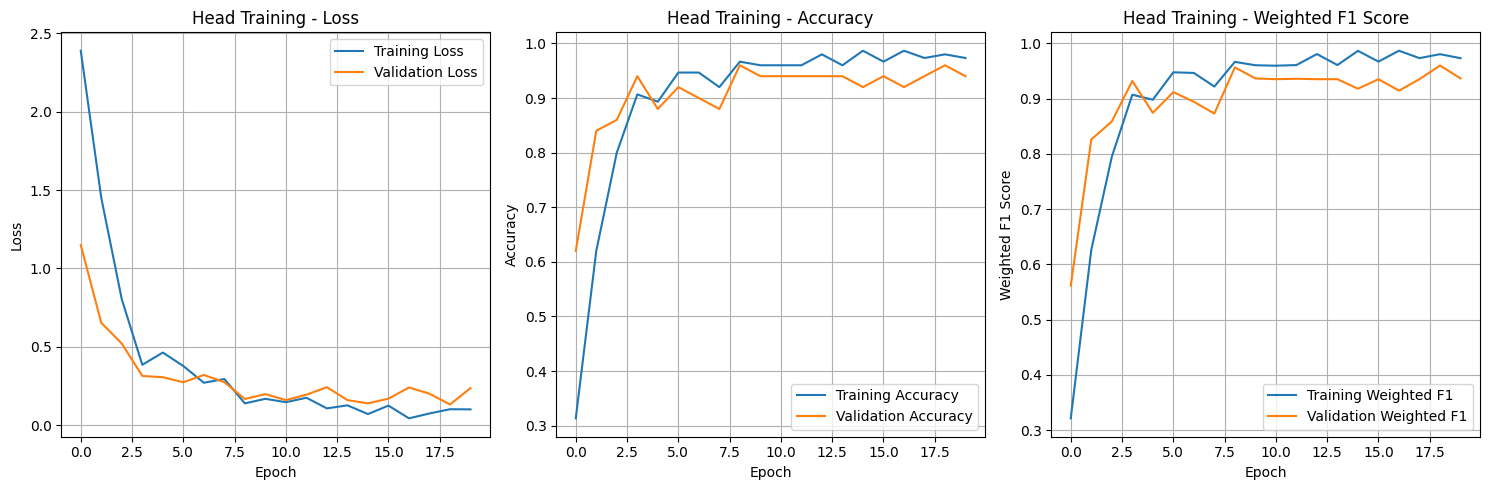

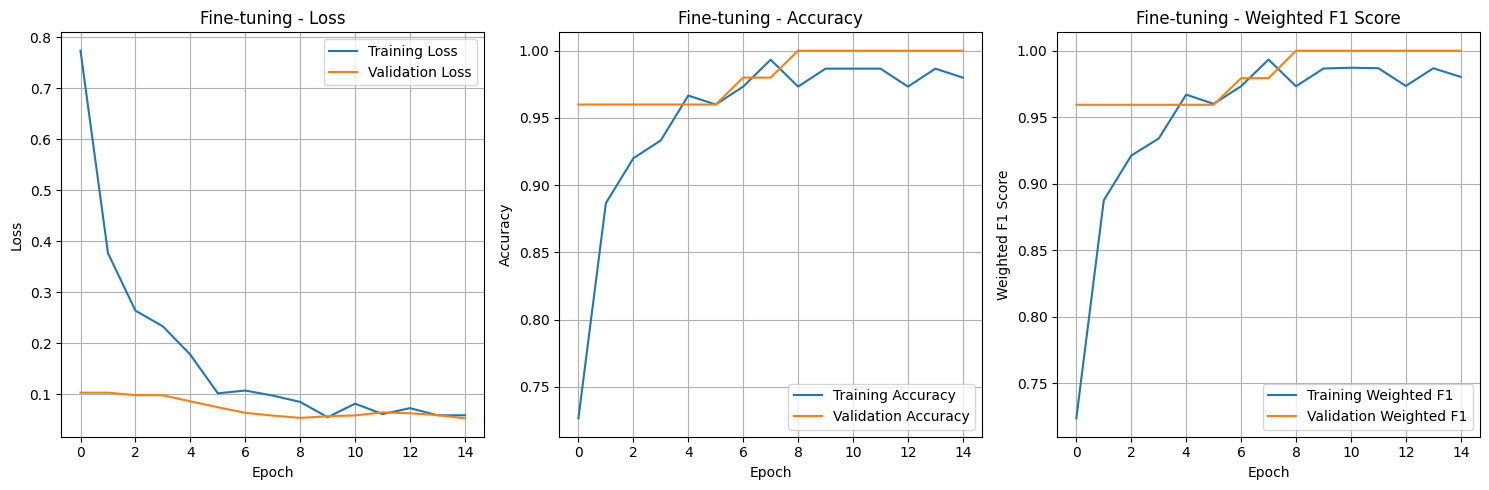

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history, title):
  df = pd.DataFrame(history.history)
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.plot(df['loss'], label='Training Loss')
  plt.plot(df['val_loss'], label='Validation Loss')
  plt.title(f'{title} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 2)
  plt.plot(df['accuracy'], label='Training Accuracy')
  plt.plot(df['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{title} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 3)
  plt.plot(df['weighted_f1'], label='Training Weighted F1')
  plt.plot(df['val_weighted_f1'], label='Validation Weighted F1')
  plt.title(f'{title} - Weighted F1 Score')
  plt.xlabel('Epoch')
  plt.ylabel('Weighted F1 Score')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

# Plot history for head training
plot_history(history_head, 'Head Training')

# Plot history for fine-tuning
plot_history(history_fine, 'Fine-tuning')


EVALUATING PHASE 1 ON TEST SET
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 767ms/step - accuracy: 1.0000 - loss: 0.0143 - weighted_f1: 1.0000

PHASE 1 - TEST SET RESULTS
Test Loss:     0.0158
Test Accuracy: 1.0000 (100.00%)
Test F1 Score: 1.0000


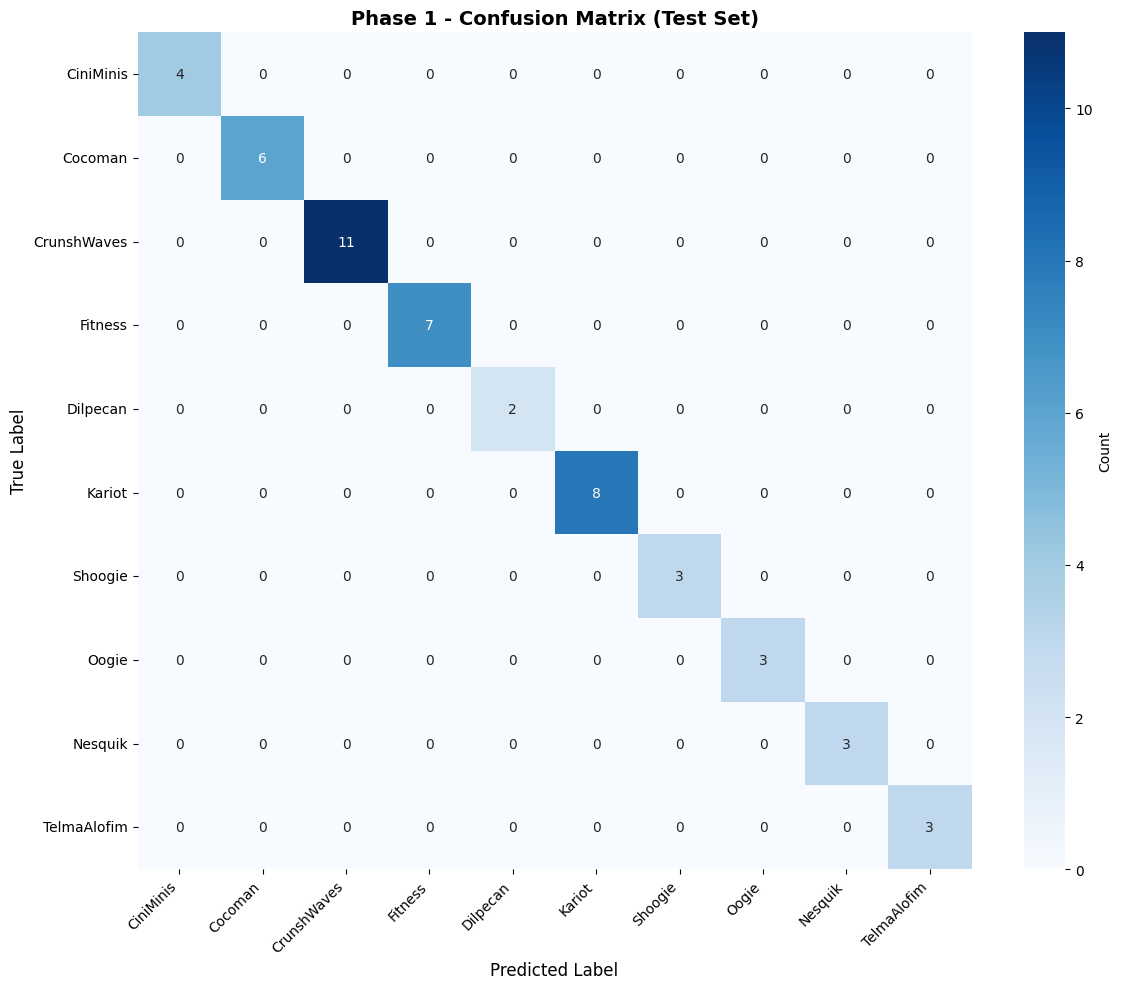


PHASE 1 - CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

   CiniMinis     1.0000    1.0000    1.0000         4
     Cocoman     1.0000    1.0000    1.0000         6
 CrunshWaves     1.0000    1.0000    1.0000        11
     Fitness     1.0000    1.0000    1.0000         7
    Dilpecan     1.0000    1.0000    1.0000         2
      Kariot     1.0000    1.0000    1.0000         8
     Shoogie     1.0000    1.0000    1.0000         3
       Oogie     1.0000    1.0000    1.0000         3
     Nesquik     1.0000    1.0000    1.0000         3
 TelmaAlofim     1.0000    1.0000    1.0000         3

    accuracy                         1.0000        50
   macro avg     1.0000    1.0000    1.0000        50
weighted avg     1.0000    1.0000    1.0000        50


PER-CLASS ACCURACY:
------------------------------------------------------------
CiniMinis           : 100.00% (4/4 correct)
Cocoman             : 100.00% (6/6 correct)
CrunshWaves         : 100.0

In [ ]:
# ==================== EVALUATE PHASE 1 ON TEST SET ====================
print("\n" + "="*60)
print("EVALUATING PHASE 1 ON TEST SET")
print("="*60)

test_loss, test_acc, test_f1 = model.evaluate(test_ds, verbose=1)

print("\n" + "="*60)
print("PHASE 1 - TEST SET RESULTS")
print("="*60)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*60)

# Get predictions for confusion matrix
y_true_phase1 = []
y_pred_phase1 = []

for imgs, labels in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_true_phase1.extend(labels.numpy())
    y_pred_phase1.extend(np.argmax(preds, axis=-1))

y_true_phase1 = np.array(y_true_phase1)
y_pred_phase1 = np.array(y_pred_phase1)

# Confusion matrix
cm_phase1 = confusion_matrix(y_true_phase1, y_pred_phase1)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_phase1,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CEREAL_CATEGORIES,
    yticklabels=CEREAL_CATEGORIES,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Phase 1 - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*60)
print("PHASE 1 - CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(
    y_true_phase1,
    y_pred_phase1,
    target_names=CEREAL_CATEGORIES,
    digits=4
))

# Per-class accuracy
print("\nPER-CLASS ACCURACY:")
print("-" * 60)
for idx, category in enumerate(CEREAL_CATEGORIES):
    mask = y_true_phase1 == idx
    if np.sum(mask) > 0:
        class_acc = np.mean(y_pred_phase1[mask] == idx)
        n_samples = np.sum(mask)
        print(f"{category:<20}: {class_acc:6.2%} ({int(class_acc*n_samples)}/{n_samples} correct)")
    else:
        print(f"{category:<20}: No test samples")


DECISION POINT: SHOULD WE FINE-TUNE?

Guidelines for deciding whether to proceed with fine-tuning:

Fine-tune if:
  - Test accuracy < 85%
  - Some classes have very poor performance (<70%)
  - Train-val gap is reasonable (<15%)

DO NOT fine-tune if:
  - Test accuracy >= 90% (already excellent)
  - Test accuracy = 100% (likely overfitting or small test set)
  - Severe overfitting detected (train-val gap >20%)

Based on your results:
  - Test accuracy: 100.00%
  - Test set size: 50 images

RECOMMENDATION: SKIP fine-tuning
  Reason: Test accuracy is already very high (>=90%)
  Action: Proceed directly to cross-validation for reliable metrics

FINE-TUNING ENABLED: False

NOTE: Even if test accuracy is 100%, this may be due to:
  1. Small test set (luck)
  2. Easy test examples
  3. Overfitting

Cross-validation will provide more reliable performance estimates.

FINE-TUNING SKIPPED
Reason: Test accuracy is already very high
Recommendation: Trust Phase 1 model and proceed to cross-validatio

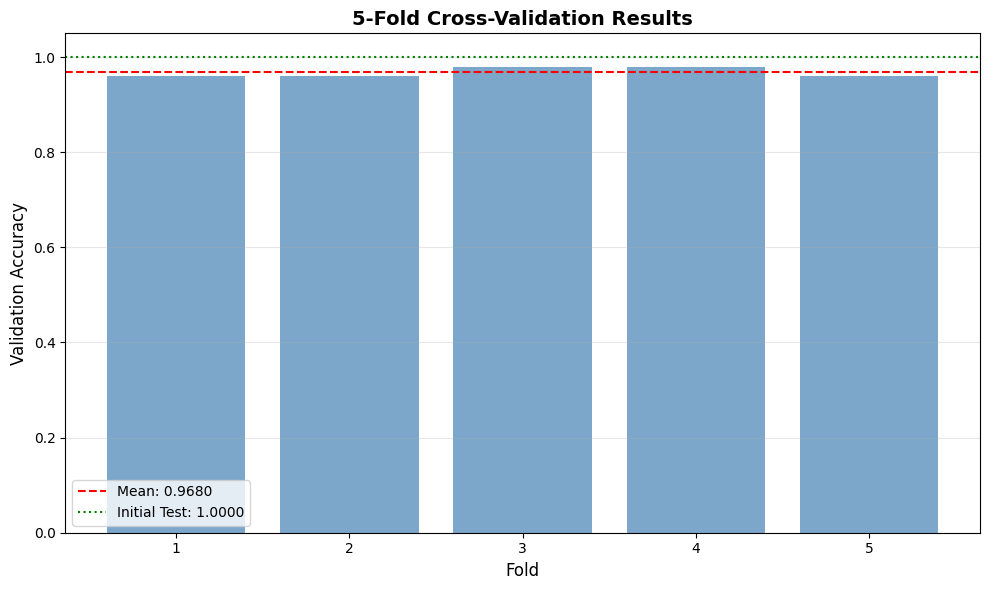

In [ ]:
# ==================== DECISION POINT: FINE-TUNING ====================
print("\n" + "="*60)
print("DECISION POINT: SHOULD WE FINE-TUNE?")
print("="*60)
print("\nGuidelines for deciding whether to proceed with fine-tuning:")
print("\nFine-tune if:")
print("  - Test accuracy < 85%")
print("  - Some classes have very poor performance (<70%)")
print("  - Train-val gap is reasonable (<15%)")
print("\nDO NOT fine-tune if:")
print("  - Test accuracy >= 90% (already excellent)")
print("  - Test accuracy = 100% (likely overfitting or small test set)")
print("  - Severe overfitting detected (train-val gap >20%)")
print("\nBased on your results:")
print(f"  - Test accuracy: {test_acc*100:.2f}%")
print(f"  - Test set size: {len(test_paths)} images")

# Automatic decision based on test accuracy
if test_acc >= 0.90:
    print("\nRECOMMENDATION: SKIP fine-tuning")
    print("  Reason: Test accuracy is already very high (>=90%)")
    print("  Action: Proceed directly to cross-validation for reliable metrics")
    ENABLE_FINETUNING = False
elif test_acc < 0.75:
    print("\nRECOMMENDATION: Consider fine-tuning")
    print("  Reason: Test accuracy is below 75%")
    print("  Action: You may try fine-tuning, but collect more data first")
    ENABLE_FINETUNING = False  # Still False by default, user can change
else:
    print("\nRECOMMENDATION: Borderline case")
    print("  Reason: Test accuracy is between 75-90%")
    print("  Action: Fine-tuning might help, but use with caution")
    ENABLE_FINETUNING = False  # User can change to True if desired

print("\n" + "="*60)
print(f"FINE-TUNING ENABLED: {ENABLE_FINETUNING}")
print("="*60)
print("\nNOTE: Even if test accuracy is 100%, this may be due to:")
print("  1. Small test set (luck)")
print("  2. Easy test examples")
print("  3. Overfitting")
print("\nCross-validation will provide more reliable performance estimates.")
print("="*60)

# ==================== FINE-TUNING (OPTIONAL) ====================
if ENABLE_FINETUNING:
    print("\n" + "="*60)
    print("PREPARING FOR PHASE 2 - FINE-TUNING")
    print("="*60)

    base_model.trainable = True

    FREEZE_UNTIL_LAYER = 200

    for layer in base_model.layers[:FREEZE_UNTIL_LAYER]:
        layer.trainable = False

    trainable_layers = sum([layer.trainable for layer in base_model.layers])

    print(f"\nBase model configuration:")
    print(f"  - Total layers: {len(base_model.layers)}")
    print(f"  - Frozen layers: {FREEZE_UNTIL_LAYER}")
    print(f"  - Trainable layers: {trainable_layers}")

    metric_f1_phase2 = WeightedF1(num_classes)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=FINETUNE_LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', metric_f1_phase2]
    )

    print(f"\nModel recompiled:")
    print(f"  - Learning rate: {FINETUNE_LEARNING_RATE} (100x lower)")
    print(f"  - Optimizer: Adam")

    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

    print(f"\nParameter count after unfreezing:")
    print(f"  - Total: {trainable_params + non_trainable_params:,}")
    print(f"  - Trainable: {trainable_params:,}")
    print(f"  - Non-trainable: {non_trainable_params:,}")
    print("="*60)

    callbacks_phase2 = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-8,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            'best_model_phase2.keras',
            monitor='val_weighted_f1',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    print("\n" + "="*60)
    print("STARTING PHASE 2 TRAINING (FINE-TUNING)")
    print("="*60)
    print(f"Epochs: {EPOCHS_FINETUNE}")
    print(f"Learning rate: {FINETUNE_LEARNING_RATE}")
    print(f"\nNote: Using very low LR to avoid catastrophic forgetting")
    print("="*60 + "\n")

    history_phase2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FINETUNE,
        class_weight=class_weights_dict,
        callbacks=callbacks_phase2,
        verbose=1
    )

    print("\n" + "="*60)
    print("PHASE 2 TRAINING COMPLETE")
    print("="*60)

    plot_training_history(history_phase2, "Phase 2 - Fine-tuning")

    print("\n" + "="*60)
    print("EVALUATING PHASE 2 ON TEST SET")
    print("="*60)

    test_loss_phase2, test_acc_phase2, test_f1_phase2 = model.evaluate(test_ds, verbose=1)

    print("\n" + "="*60)
    print("PHASE 2 - TEST SET RESULTS")
    print("="*60)
    print(f"Test Loss:     {test_loss_phase2:.4f}")
    print(f"Test Accuracy: {test_acc_phase2:.4f} ({test_acc_phase2*100:.2f}%)")
    print(f"Test F1 Score: {test_f1_phase2:.4f}")
    print("\nComparison with Phase 1:")
    print(f"  Accuracy change: {(test_acc_phase2 - test_acc)*100:+.2f}%")
    print(f"  F1 change: {(test_f1_phase2 - test_f1):+.4f}")
    print("="*60)

    y_true_phase2 = []
    y_pred_phase2 = []

    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true_phase2.extend(labels.numpy())
        y_pred_phase2.extend(np.argmax(preds, axis=-1))

    y_true_phase2 = np.array(y_true_phase2)
    y_pred_phase2 = np.array(y_pred_phase2)

    cm_phase2 = confusion_matrix(y_true_phase2, y_pred_phase2)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_phase2,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=CEREAL_CATEGORIES,
        yticklabels=CEREAL_CATEGORIES,
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Phase 2 - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("PHASE 2 - CLASSIFICATION REPORT (TEST SET)")
    print("="*60)
    print(classification_report(
        y_true_phase2,
        y_pred_phase2,
        target_names=CEREAL_CATEGORIES,
        digits=4
    ))

else:
    print("\n" + "="*60)
    print("FINE-TUNING SKIPPED")
    print("="*60)
    if test_acc >= 0.90:
        print("Reason: Test accuracy is already very high")
        print("Recommendation: Trust Phase 1 model and proceed to cross-validation")
    else:
        print("To enable fine-tuning, set ENABLE_FINETUNING = True above")
    print("="*60)

# ==================== K-FOLD CROSS-VALIDATION ====================
print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION - MOST RELIABLE EVALUATION")
print("="*60)
print("\nWhy cross-validation is important:")
print(f"  - Your test set has only {len(test_paths)} images")
print("  - Some classes have very few test samples")
print("  - 100% on a small test set may not reflect true performance")
print("\nCross-validation will:")
print("  - Test on ALL 250 images (in 5 different splits)")
print("  - Give more reliable accuracy estimates")
print("  - Show if your 100% test accuracy was real or lucky")
print("\nThis will train 5 separate models - please be patient.")
print("="*60)

N_SPLITS = 5
RUN_KFOLD = True  # Set to False to skip (not recommended)

if RUN_KFOLD:
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    cv_scores = {
        'accuracy': [],
        'f1': [],
        'loss': []
    }

    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(all_paths, all_labels)):
        print("\n" + "="*60)
        print(f"FOLD {fold + 1}/{N_SPLITS}")
        print("="*60)

        fold_train_paths = all_paths[train_idx]
        fold_train_labels = all_labels[train_idx]
        fold_val_paths = all_paths[val_idx]
        fold_val_labels = all_labels[val_idx]

        print(f"Train: {len(fold_train_paths)} images")
        print(f"Val:   {len(fold_val_paths)} images")

        fold_train_ds = create_dataset(fold_train_paths, fold_train_labels,
                                       augment=True, shuffle=True)
        fold_val_ds = create_dataset(fold_val_paths, fold_val_labels,
                                     augment=False, shuffle=False)

        tf.keras.backend.clear_session()

        inputs_fold = layers.Input(shape=IMG_SIZE + (3,))
        base_model_fold = MobileNetV2(
            input_shape=IMG_SIZE + (3,),
            include_top=False,
            weights='imagenet'
        )
        base_model_fold.trainable = False

        x_fold = base_model_fold(inputs_fold, training=False)
        x_fold = layers.GlobalAveragePooling2D()(x_fold)
        x_fold = layers.Dropout(0.5)(x_fold)
        x_fold = layers.Dense(128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_fold)
        x_fold = layers.Dropout(0.3)(x_fold)
        outputs_fold = layers.Dense(num_classes, activation='softmax')(x_fold)

        model_fold = models.Model(inputs_fold, outputs_fold)

        metric_f1_fold = WeightedF1(num_classes)
        model_fold.compile(
            optimizer=optimizers.Adam(INITIAL_LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', metric_f1_fold]
        )

        callbacks_fold = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                restore_best_weights=True,
                verbose=0
            )
        ]

        fold_class_weights = {
            i: len(fold_train_labels) / (num_classes * np.sum(fold_train_labels == i))
            for i in range(num_classes)
        }

        history_fold = model_fold.fit(
            fold_train_ds,
            validation_data=fold_val_ds,
            epochs=EPOCHS_HEAD,
            class_weight=fold_class_weights,
            callbacks=callbacks_fold,
            verbose=0
        )

        val_loss, val_acc, val_f1 = model_fold.evaluate(fold_val_ds, verbose=0)

        cv_scores['loss'].append(val_loss)
        cv_scores['accuracy'].append(val_acc)
        cv_scores['f1'].append(val_f1)
        fold_histories.append(history_fold)

        print(f"\nFold {fold + 1} Results:")
        print(f"  Val Loss:     {val_loss:.4f}")
        print(f"  Val Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
        print(f"  Val F1 Score: {val_f1:.4f}")

    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS (5-FOLD)")
    print("="*60)
    print(f"\nAccuracy:")
    print(f"  Mean: {np.mean(cv_scores['accuracy']):.4f} ({np.mean(cv_scores['accuracy'])*100:.2f}%)")
    print(f"  Std:  {np.std(cv_scores['accuracy']):.4f} (±{np.std(cv_scores['accuracy'])*100:.2f}%)")
    print(f"  Min:  {np.min(cv_scores['accuracy']):.4f}")
    print(f"  Max:  {np.max(cv_scores['accuracy']):.4f}")

    print(f"\nWeighted F1:")
    print(f"  Mean: {np.mean(cv_scores['f1']):.4f}")
    print(f"  Std:  {np.std(cv_scores['f1']):.4f}")
    print(f"  Min:  {np.min(cv_scores['f1']):.4f}")
    print(f"  Max:  {np.max(cv_scores['f1']):.4f}")

    print(f"\nLoss:")
    print(f"  Mean: {np.mean(cv_scores['loss']):.4f}")
    print(f"  Std:  {np.std(cv_scores['loss']):.4f}")

    print("\n" + "="*60)
    print("INTERPRETATION:")
    print("="*60)

    mean_acc = np.mean(cv_scores['accuracy'])
    std_acc = np.std(cv_scores['accuracy'])

    print(f"\nCross-validation accuracy: {mean_acc*100:.1f}% ± {std_acc*100:.1f}%")
    print(f"This is your model's TRUE performance on unseen data")
    print(f"\n95% Confidence interval: {(mean_acc - 2*std_acc)*100:.1f}% to {(mean_acc + 2*std_acc)*100:.1f}%")

    # Compare with initial test set results
    print(f"\nComparison:")
    print(f"  Initial test accuracy: {test_acc*100:.2f}% (on {len(test_paths)} images)")
    print(f"  Cross-validation accuracy: {mean_acc*100:.1f}% (on all {len(all_paths)} images)")

    if test_acc == 1.0 and mean_acc < 0.95:
        print(f"\nNote: Your 100% test accuracy was likely due to:")
        print(f"  - Small test set ({len(test_paths)} images)")
        print(f"  - Happened to be easy examples")
        print(f"  Cross-validation shows more realistic performance")
    elif abs(test_acc - mean_acc) < 0.05:
        print(f"\nNote: Test accuracy and cross-validation agree closely")
        print(f"  Your model performance is consistent")

    # Variance interpretation
    if std_acc < 0.05:
        print("\nVariance: LOW - Model is very stable across different data splits")
    elif std_acc < 0.10:
        print("\nVariance: MODERATE - Some variation across folds (expected for small datasets)")
    else:
        print("\nVariance: HIGH - Model performance is inconsistent")
        print("  Recommendation: Collect more data or use stronger regularization")

    # Performance assessment
    if mean_acc >= 0.90:
        print("\nPerformance: EXCELLENT")
        print("  Your model generalizes very well")
    elif mean_acc >= 0.80:
        print("\nPerformance: GOOD")
        print("  Your model performs well for this dataset size")
    elif mean_acc >= 0.70:
        print("\nPerformance: ACCEPTABLE")
        print("  Consider collecting more data to improve performance")
    else:
        print("\nPerformance: NEEDS IMPROVEMENT")
        print("  Recommendations:")
        print("    - Collect more training data")
        print("    - Try data augmentation techniques")
        print("    - Experiment with different architectures")

    print("\n" + "="*60)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, N_SPLITS+1), cv_scores['accuracy'], color='steelblue', alpha=0.7)
    plt.axhline(y=np.mean(cv_scores['accuracy']), color='red', linestyle='--',
                label=f"Mean: {np.mean(cv_scores['accuracy']):.4f}")
    plt.axhline(y=test_acc, color='green', linestyle=':',
                label=f"Initial Test: {test_acc:.4f}")
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.title('5-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.show()

else:
    print("\nWARNING: Cross-validation skipped")
    print("This is NOT recommended for small datasets")
    print("Your test set results may not reflect true performance")
    print("Set RUN_KFOLD = True to get reliable metrics")